In [1]:
import tensorflow as tf
import numpy as np
import scipy.misc
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.python.framework.ops import EagerTensor
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import keras
import cv2

In [2]:
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize image vectors
X_train = X_train/ 255.
X_test = X_test/ 255.

X_train = tf.image.resize(X_train, [64,64])

X_test = tf.image.resize(X_test, [64,64])

# Convert training and test labels to one hot matrices
Y_train = tf.one_hot(Y_train, 10)
Y_train = np.squeeze(Y_train)
Y_test = tf.one_hot(Y_test, 10)
Y_test = np.squeeze(Y_test)

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 50000
number of test examples = 10000
X_train shape: (50000, 64, 64, 3)
Y_train shape: (50000, 10)
X_test shape: (10000, 64, 64, 3)
Y_test shape: (10000, 10)


In [3]:
base_model = tf.keras.applications.ResNet50(
    weights='imagenet',
    input_shape=(64, 64, 3),
    include_top=False
)

# Freeze the base model layers
base_model.trainable = False

# Add classification layers on top of ResNet-50
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')  # CIFAR-10 has 10 classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [4]:
history = model.fit(X_train, Y_train,
                    epochs=20,
                    batch_size=64,
                    validation_data=(X_test, Y_test))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, Y_test)
print(f"Test accuracy: {test_accuracy}")

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 46s 42ms/step - accuracy: 0.1921 - loss: 2.1869 - val_accuracy: 0.3132 - val_loss: 1.8986
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.2839 - loss: 1.9346 - val_accuracy: 0.3285 - val_loss: 1.8397
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 27ms/step - accuracy: 0.3060 - loss: 1.8821 - val_accuracy: 0.3416 - val_loss: 1.8123
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 27ms/step - accuracy: 0.3214 - loss: 1.8478 - val_accuracy: 0.3465 - val_loss: 1.7926
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 28ms/step - accuracy: 0.3312 - loss: 1.8316 - val_accuracy: 0.3564 - val_loss: 1.7672
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 28ms/step - accuracy: 0.3390 - loss: 1.8120 - val_accuracy: 0.3683 - val_loss: 1.7472
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.3451 - loss: 1.7992 - val_accuracy: 0.3535 - val_loss: 1.7655
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 27ms/step - accuracy: 0.3492 - loss: 1.7846 - 

In [6]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])

# Load the ResNet-50 model with adjusted input shape and exclude top layers
base_model = tf.keras.applications.ResNet50(
    weights='imagenet',
    input_shape=(64, 64, 3),
    include_top=False
)

# Unfreeze the last few layers of ResNet50 for fine-tuning
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Add classification layers on top of ResNet-50
model = tf.keras.Sequential([
    data_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')  # CIFAR-10 has 10 classes
])

# Compile the model with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Set up learning rate scheduling
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

# Train the model for more epochs
history = model.fit(X_train, Y_train,
                    epochs=12,
                    batch_size=64,
                    validation_data=(X_test, Y_test),
                    callbacks=[lr_scheduler])

Epoch 1/12
782/782 ━━━━━━━━━━━━━━━━━━━━ 156s 151ms/step - accuracy: 0.5572 - loss: 1.3793 - val_accuracy: 0.3637 - val_loss: 2.1501 - learning_rate: 1.0000e-04
Epoch 2/12
782/782 ━━━━━━━━━━━━━━━━━━━━ 139s 147ms/step - accuracy: 0.8303 - loss: 0.5006 - val_accuracy: 0.8678 - val_loss: 0.3910 - learning_rate: 1.0000e-04
Epoch 3/12
782/782 ━━━━━━━━━━━━━━━━━━━━ 142s 148ms/step - accuracy: 0.8684 - loss: 0.3826 - val_accuracy: 0.8748 - val_loss: 0.3707 - learning_rate: 1.0000e-04
Epoch 4/12
782/782 ━━━━━━━━━━━━━━━━━━━━ 141s 146ms/step - accuracy: 0.8918 - loss: 0.3120 - val_accuracy: 0.8886 - val_loss: 0.3395 - learning_rate: 1.0000e-04
Epoch 5/12
782/782 ━━━━━━━━━━━━━━━━━━━━ 142s 147ms/step - accuracy: 0.9104 - loss: 0.2654 - val_accuracy: 0.8897 - val_loss: 0.3350 - learning_rate: 1.0000e-04
Epoch 6/12
782/782 ━━━━━━━━━━━━━━━━━━━━ 143s 148ms/step - accuracy: 0.9168 - loss: 0.2393 - val_accuracy: 0.8808 - val_loss: 0.3648 - learning_rate: 1.0000e-04
Epoch 7/12
782/782 ━━━━━━━━━━━━━━━━━━━━ 

In [8]:
test_loss, test_accuracy = model.evaluate(X_test, Y_test)
print(f"Test accuracy: {test_accuracy}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.9139 - loss: 0.3043
Test accuracy: 0.9128999710083008


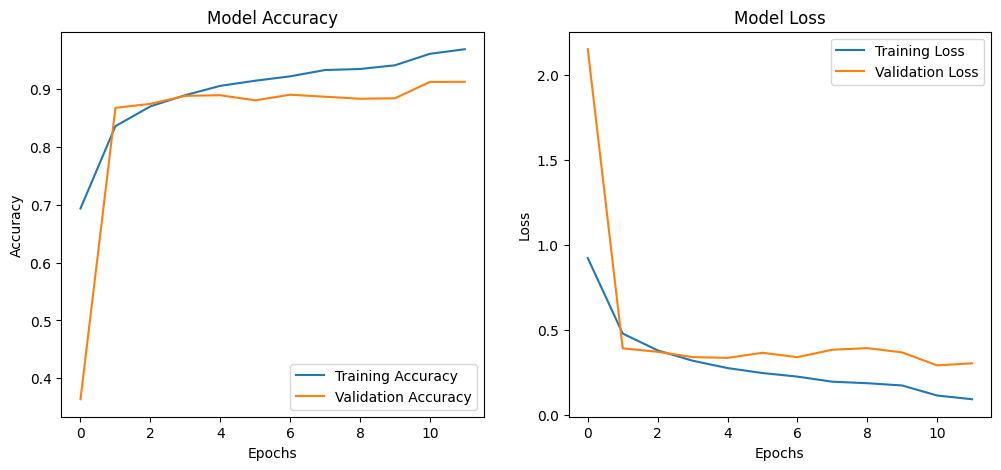

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step


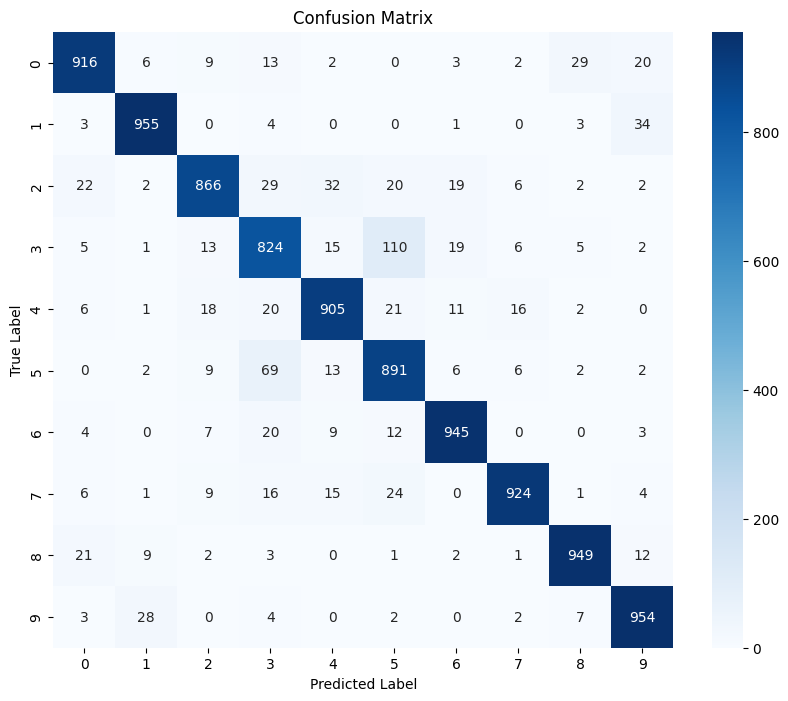

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Plot training & validation accuracy and loss
def plot_training_history(history):
    # Accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Call the function to plot training history
plot_training_history(history)

# Confusion Matrix
# Get predictions on the test set
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_test, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(Y_true, Y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
